# Target Encoder’s Internal Cross fitting
- `TargetEncoder`는 범주형 특징의 각 범주를 해당 범주에 대한 대상 변수의 축소된 평균으로 대체

## Create Synthetic Dataset

In [1]:
import numpy as np

from sklearn.preprocessing import KBinsDiscretizer

n_samples = 50_000

rng = np.random.RandomState(42)
y = rng.randn(n_samples)
noise = 0.5 * rng.randn(n_samples)
n_categories = 100

kbins = KBinsDiscretizer(
    n_bins=n_categories,
    encode="ordinal",
    strategy="uniform",
    random_state=rng,
    subsample=None,
)
X_informative = kbins.fit_transform((y + noise).reshape(-1, 1))

# X_informative의 값을 순열하여 y와 구간차원 인덱스 사이의 선형 관계를 제거
permuted_categories = rng.permutation(n_categories)
X_informative = permuted_categories[X_informative.astype(np.int32)]

In [2]:
X_shuffled = rng.permutation(X_informative)

In [3]:
X_near_unique_categories = rng.choice(
    int(0.9 * n_samples), size=n_samples, replace=True
).reshape(-1, 1)

In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split

X = pd.DataFrame(
    np.concatenate(
        [X_informative, X_shuffled, X_near_unique_categories],
        axis=1,
    ),
    columns=["informative", "shuffled", "near_unique"],
)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Training a Ridge Regressor

In [5]:
import sklearn
from sklearn.linear_model import Ridge

# 항상 데이터프레임을 출력하도록 트랜스포머 구성
sklearn.set_config(transform_output="pandas")

ridge = Ridge(alpha=1e-6, solver="lsqr", fit_intercept=False)

raw_model = ridge.fit(X_train, y_train)
print("Raw Model score on training set: ", raw_model.score(X_train, y_train))
print("Raw Model score on test set: ", raw_model.score(X_test, y_test))

Raw Model score on training set:  0.0049896314219657345
Raw Model score on test set:  0.004577621581423719


In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import TargetEncoder

model_with_cf = make_pipeline(TargetEncoder(random_state=0), ridge)
model_with_cf.fit(X_train, y_train)
print("Model with CF on train set: ", model_with_cf.score(X_train, y_train))
print("Model with CF on test set: ", model_with_cf.score(X_test, y_test))

Model with CF on train set:  0.8000184677460287
Model with CF on test set:  0.7927845601690936


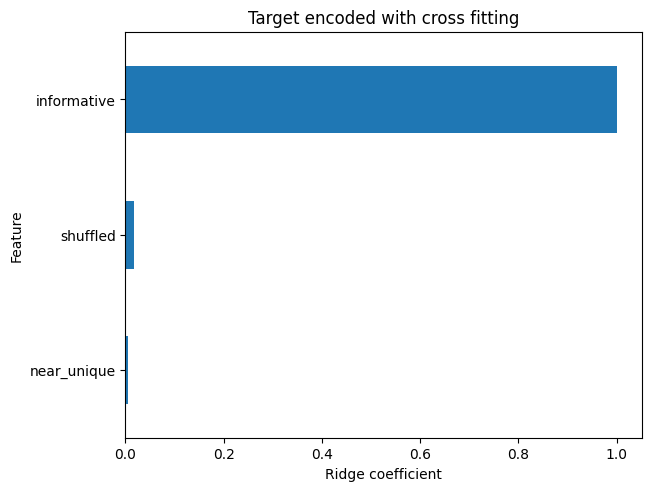

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.constrained_layout.use"] = True

coefs_cf = pd.Series(
    model_with_cf[-1].coef_, index=model_with_cf[-1].feature_names_in_
).sort_values()
ax = coefs_cf.plot(kind="barh")
_ = ax.set(
    title="Target encoded with cross fitting",
    xlabel="Ridge coefficient",
    ylabel="Feature",
)

In [8]:
target_encoder = TargetEncoder(random_state=0)
target_encoder.fit(X_train, y_train)
X_train_no_cf_encoding = target_encoder.transform(X_train)
X_test_no_cf_encoding = target_encoder.transform(X_test)

model_no_cf = ridge.fit(X_train_no_cf_encoding, y_train)

In [9]:
print(
    "Model without CF on training set: ",
    model_no_cf.score(X_train_no_cf_encoding, y_train),
)
print(
    "Model without CF on test set: ",
    model_no_cf.score(
        X_test_no_cf_encoding,
        y_test,
    ),
)

Model without CF on training set:  0.858486250088675
Model without CF on test set:  0.6338211367107183


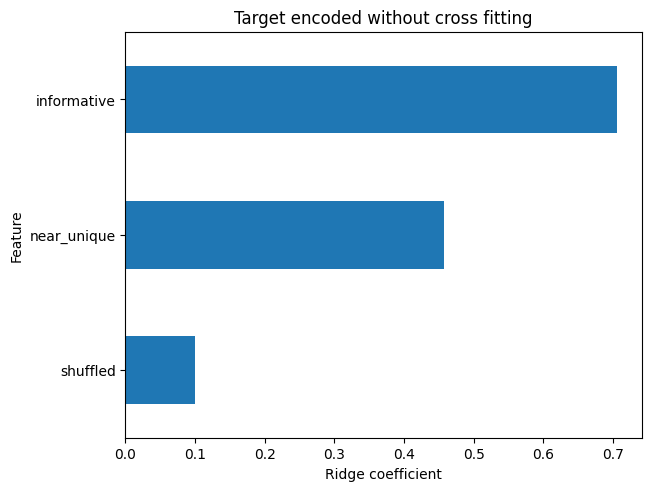

In [10]:
coefs_no_cf = pd.Series(
    model_no_cf.coef_, index=model_no_cf.feature_names_in_
).sort_values()
ax = coefs_no_cf.plot(kind="barh")
_ = ax.set(
    title="Target encoded without cross fitting",
    xlabel="Ridge coefficient",
    ylabel="Feature",
)